# 01 U-Net基线模型实验

## 目标
- 实现U-Net基线模型（仅L1损失，无GAN）
- 数据增强消融实验（无增强、基础增强、强增强）
- 训练过程可视化（损失曲线、三联图）
- 评估指标记录（PSNR、SSIM、MAE）

## 模型架构
- 与Pix2Pix生成器相同的U-Net结构
- 编码器：C64-C128-C256-C512-C512-C512-C512-C512
- 解码器：CD512-CD512-CD512-C512-C256-C128-C64
- Skip Connections：编码器第i层连接到解码器第n-i层

## 训练设置
- 优化器：Adam, lr=2e-4
- 学习率调度：线性衰减（从epoch 100开始）
- 训练轮数：200 epochs
- Batch size：1
- 损失函数：仅L1损失



## Colab环境设置

### 📦 数据同步方案（三选一）

#### 方案一：Google Drive for Desktop（推荐，最简单）
1. **安装 Google Drive for Desktop**：https://www.google.com/drive/download/
2. **设置同步文件夹**：
   - 将项目文件夹添加到Google Drive同步目录
   - 本地修改会自动同步到云端
   - 在Colab中直接使用同步后的文件，无需手动上传

#### 方案二：Git + GitHub（推荐，适合代码）
1. **将代码推送到GitHub**（数据文件用Git LFS或单独上传）
2. **在Colab中直接克隆**：代码会自动从GitHub拉取最新版本
3. **优点**：版本控制、自动同步、无需压缩上传

#### 方案三：手动上传（备选）
如果使用手动上传，请将以下文件压缩：
- `src/` 目录（源代码）
- `data/splits/cityscapes_split_seed42.json`（数据划分文件）
- `data/processed/` 目录（图像数据，可压缩为 `data_processed.zip`）

---

### 📝 使用说明

**如果使用方案一（Google Drive同步）**：
- 确保项目文件夹已在Google Drive中同步
- 直接运行下面的代码，会自动检测并使用同步的文件

**如果使用方案二（GitHub）**：
- 在下面的代码中设置 `USE_GITHUB = True` 并填写仓库地址
- 代码会自动克隆最新版本

**如果使用方案三（手动上传）**：
- 上传压缩包到Google Drive
- 代码会自动解压



In [ ]:
# ============================================
# Colab环境设置：支持多种同步方案
# ============================================

# 先导入依赖
import os
from pathlib import Path
import zipfile
import shutil
import subprocess
import sys
from google.colab import drive

# ========== 配置区域 ==========
# 选择同步方案：'github', 'drive_sync', 'manual'
SYNC_METHOD = 'github'  # 或 'drive_sync' 或 'manual'

# GitHub配置（如果使用方案二）
GITHUB_REPO = "AltheD/Image-to-Image-Translation-Experiment"  # 替换为你的GitHub仓库地址
GITHUB_BRANCH = "main"  # 或 "master"

# Google Drive配置（如果使用方案一或三）
DRIVE_PROJECT_DIR = Path("/content/drive/MyDrive/Image-to-Image-Translation-Experiment")
# ==============================

COLAB_WORK_DIR = Path("/content/Image-to-Image-Translation-Experiment")

# 1. 挂载Google Drive（所有方案都需要）
print("正在挂载Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive挂载完成！")

# 2. 根据选择的方案设置项目
if SYNC_METHOD == 'github':
    # 方案二：从GitHub克隆
    print(f"\n📦 从GitHub克隆项目: {GITHUB_REPO}")
    if COLAB_WORK_DIR.exists():
        print("⚠️  项目目录已存在，拉取最新代码")
        subprocess.run(["git", "-C", str(COLAB_WORK_DIR), "pull"], check=True)
    else:
        repo_url = f"https://github.com/{GITHUB_REPO}.git"
        subprocess.run(["git", "clone", "-b", GITHUB_BRANCH, repo_url, str(COLAB_WORK_DIR)], check=True)
        print("✅ GitHub克隆完成！")

    # 检查数据文件（GitHub通常不包含大数据文件）
    if not (COLAB_WORK_DIR / "data" / "processed").exists():
        print("\n⚠️  检测到数据文件缺失，尝试从Google Drive复制...")
        if (DRIVE_PROJECT_DIR / "data" / "processed").exists():
            (COLAB_WORK_DIR / "data").mkdir(parents=True, exist_ok=True)
            if (COLAB_WORK_DIR / "data" / "processed").exists():
                if (COLAB_WORK_DIR / "data" / "processed").is_symlink():
                    print("✅ 数据目录符号链接已存在")
                else:
                    shutil.rmtree(COLAB_WORK_DIR / "data" / "processed")
                    os.symlink(DRIVE_PROJECT_DIR / "data" / "processed",
                              COLAB_WORK_DIR / "data" / "processed")
                    print("✅ 数据目录符号链接创建完成！")
            else:
                os.symlink(DRIVE_PROJECT_DIR / "data" / "processed",
                          COLAB_WORK_DIR / "data" / "processed")
                print("✅ 数据目录符号链接创建完成！")
        else:
            print("❌ 未找到数据文件，请确保已上传到Google Drive")

    os.chdir(COLAB_WORK_DIR)

elif SYNC_METHOD == 'drive_sync':
    # 方案一：使用Google Drive同步的文件（直接使用，无需解压）
    print("\n📁 使用Google Drive同步的文件...")
    if not DRIVE_PROJECT_DIR.exists():
        print(f"❌ 未找到项目目录: {DRIVE_PROJECT_DIR}")
        print("   请确保已安装Google Drive for Desktop并同步项目文件夹")
    else:
        print(f"✅ 找到项目目录: {DRIVE_PROJECT_DIR}")
        # 创建符号链接或直接使用（如果数据在Drive中）
        if not COLAB_WORK_DIR.exists():
            COLAB_WORK_DIR.mkdir(parents=True, exist_ok=True)

        # 复制源代码（小文件）
        if (DRIVE_PROJECT_DIR / "src").exists():
            if (COLAB_WORK_DIR / "src").exists():
                shutil.rmtree(COLAB_WORK_DIR / "src")
            shutil.copytree(DRIVE_PROJECT_DIR / "src", COLAB_WORK_DIR / "src")
            print("✅ 源代码已复制")

        # 数据文件使用符号链接（节省空间和时间）
        (COLAB_WORK_DIR / "data").mkdir(parents=True, exist_ok=True)
        if (DRIVE_PROJECT_DIR / "data" / "splits").exists():
            (COLAB_WORK_DIR / "data" / "splits").mkdir(parents=True, exist_ok=True)
            if not (COLAB_WORK_DIR / "data" / "splits" / "cityscapes_split_seed42.json").exists():
                shutil.copy2(DRIVE_PROJECT_DIR / "data" / "splits" / "cityscapes_split_seed42.json",
                            COLAB_WORK_DIR / "data" / "splits" / "cityscapes_split_seed42.json")
            print("✅ 数据划分文件已复制")

        if (DRIVE_PROJECT_DIR / "data" / "processed").exists():
            if (COLAB_WORK_DIR / "data" / "processed").exists():
                if not (COLAB_WORK_DIR / "data" / "processed").is_symlink():
                    shutil.rmtree(COLAB_WORK_DIR / "data" / "processed")
                    os.symlink(DRIVE_PROJECT_DIR / "data" / "processed",
                              COLAB_WORK_DIR / "data" / "processed")
            else:
                os.symlink(DRIVE_PROJECT_DIR / "data" / "processed",
                          COLAB_WORK_DIR / "data" / "processed")
            print("✅ 数据目录符号链接已创建")

        os.chdir(COLAB_WORK_DIR)

else:
    # 方案三：手动上传（解压zip文件）
    print("\n📦 使用手动上传的文件（解压模式）...")
    COLAB_WORK_DIR.mkdir(parents=True, exist_ok=True)
    os.chdir(COLAB_WORK_DIR)

    # 3. 解压项目文件（仅手动上传模式需要）
    project_zip = DRIVE_PROJECT_DIR / "project.zip"
    src_zip = DRIVE_PROJECT_DIR / "src.zip"
    data_splits_zip = DRIVE_PROJECT_DIR / "data_splits.zip"
    data_processed_zip = DRIVE_PROJECT_DIR / "data_processed.zip"

    def extract_if_needed(zip_path, target_dir, description):
        """如果目标目录不存在，则解压zip文件"""
        target_path = COLAB_WORK_DIR / target_dir
        if not target_path.exists() or not any(target_path.iterdir()):
            if zip_path.exists():
                print(f"正在解压 {description}...")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(COLAB_WORK_DIR)
                print(f"✅ {description} 解压完成！")
            else:
                print(f"⚠️  警告：未找到 {zip_path}")
                print(f"   请确保已上传文件到Google Drive，或手动解压到 {target_path}")
        else:
            print(f"✅ {description} 已存在，跳过解压")

    # 解压源代码
    if project_zip.exists():
        extract_if_needed(project_zip, ".", "项目文件")
    elif src_zip.exists():
        extract_if_needed(src_zip, "src", "源代码")
    else:
        # 尝试从已存在的目录复制
        if (DRIVE_PROJECT_DIR / "src").exists():
            print("正在复制源代码目录...")
            if (COLAB_WORK_DIR / "src").exists():
                shutil.rmtree(COLAB_WORK_DIR / "src")
            shutil.copytree(DRIVE_PROJECT_DIR / "src", COLAB_WORK_DIR / "src")
            print("✅ 源代码复制完成！")
        else:
            print("⚠️  警告：未找到源代码文件，请检查路径")

    # 解压数据划分文件
    if data_splits_zip.exists():
        extract_if_needed(data_splits_zip, "data/splits", "数据划分文件")
    elif (DRIVE_PROJECT_DIR / "data" / "splits").exists():
        print("正在复制数据划分文件...")
        (COLAB_WORK_DIR / "data" / "splits").mkdir(parents=True, exist_ok=True)
        shutil.copy2(DRIVE_PROJECT_DIR / "data" / "splits" / "cityscapes_split_seed42.json",
                     COLAB_WORK_DIR / "data" / "splits" / "cityscapes_split_seed42.json")
        print("✅ 数据划分文件复制完成！")

    # 解压图像数据（如果数据较大，建议使用符号链接而不是复制）
    if data_processed_zip.exists():
        extract_if_needed(data_processed_zip, "data/processed", "图像数据")
    elif (DRIVE_PROJECT_DIR / "data" / "processed").exists():
        print("正在创建数据目录符号链接（节省空间）...")
        (COLAB_WORK_DIR / "data").mkdir(parents=True, exist_ok=True)
        if (COLAB_WORK_DIR / "data" / "processed").exists():
            if (COLAB_WORK_DIR / "data" / "processed").is_symlink():
                print("✅ 数据目录符号链接已存在")
            else:
                shutil.rmtree(COLAB_WORK_DIR / "data" / "processed")
                os.symlink(DRIVE_PROJECT_DIR / "data" / "processed",
                          COLAB_WORK_DIR / "data" / "processed")
                print("✅ 数据目录符号链接创建完成！")
        else:
            os.symlink(DRIVE_PROJECT_DIR / "data" / "processed",
                      COLAB_WORK_DIR / "data" / "processed")
            print("✅ 数据目录符号链接创建完成！")
    else:
        print("⚠️  警告：未找到图像数据，请检查路径")

# 4. 安装依赖包
print("\n📦 正在检查并安装依赖包...")

packages = [
    "torch",
    "torchvision",
    "pillow",
    "matplotlib",
    "numpy",
    "tqdm",
    "scikit-image",  # 用于PSNR和SSIM计算
    "pandas",  # 用于数据分析
]

for package in packages:
    try:
        __import__(package if package != "pillow" else "PIL")
        print(f"✅ {package} 已安装")
    except ImportError:
        print(f"正在安装 {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✅ {package} 安装完成")

print("\n✅ 环境设置完成！")
print(f"当前工作目录：{os.getcwd()}")
print(f"项目根目录：{COLAB_WORK_DIR}")
print(f"同步方式：{SYNC_METHOD}")

# 验证关键文件是否存在
print("\n📋 验证项目文件...")
required_files = [
    ("src/models/unet_baseline.py", "模型文件"),
    ("src/data/dataset.py", "数据集文件"),
    ("src/data/transforms.py", "数据变换文件"),
    ("data/splits/cityscapes_split_seed42.json", "数据划分文件"),
]

all_ok = True
for file_path, description in required_files:
    full_path = COLAB_WORK_DIR / file_path
    if full_path.exists():
        print(f"✅ {description}: {file_path}")
    else:
        print(f"❌ {description} 缺失: {file_path}")
        all_ok = False

if all_ok:
    print("\n🎉 所有必需文件已就绪，可以开始训练！")
else:
    print("\n⚠️  部分文件缺失，请检查同步设置")



正在挂载Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive挂载完成！

📦 从GitHub克隆项目: AltheD/Image-to-Image-Translation-Experiment
⚠️  项目目录已存在，拉取最新代码

📦 正在检查并安装依赖包...
✅ torch 已安装
✅ torchvision 已安装
✅ pillow 已安装
✅ matplotlib 已安装
✅ numpy 已安装
✅ tqdm 已安装

✅ 环境设置完成！
当前工作目录：/content/Image-to-Image-Translation-Experiment
项目根目录：/content/Image-to-Image-Translation-Experiment
同步方式：github

📋 验证项目文件...
✅ 模型文件: src/models/unet_baseline.py
✅ 数据集文件: src/data/dataset.py
✅ 数据变换文件: src/data/transforms.py
✅ 数据划分文件: data/splits/cityscapes_split_seed42.json

🎉 所有必需文件已就绪，可以开始训练！


In [ ]:
# 导入库
import sys
from pathlib import Path
import os

# 添加项目根目录到路径（适配Colab环境）
# 检测是否在Colab环境中运行
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # 在Colab中，使用之前设置的COLAB_WORK_DIR
    try:
        ROOT = COLAB_WORK_DIR
    except NameError:
        # 如果COLAB_WORK_DIR未定义，使用默认路径
        ROOT = Path("/content/Image-to-Image-Translation-Experiment")
else:
    # 本地环境，使用相对路径
    ROOT = Path("..").resolve()

sys.path.insert(0, str(ROOT))
print(f"项目根目录：{ROOT}")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import json

from src.models.unet_baseline import UNetBaseline
from src.data.dataset import CityscapesDataset
from src.data.transforms import build_transform
from src.eval.metrics import evaluate_batch, calculate_psnr, calculate_ssim, calculate_mae

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据路径
DATA_ROOT = ROOT / "data"
SPLIT_INDEX = ROOT / "data" / "splits" / "cityscapes_split_seed42.json"

# 输出根目录和子目录（与项目整体约定保持一致）
OUTPUT_ROOT = ROOT / "outputs"
CHECKPOINT_DIR = OUTPUT_ROOT / "checkpoints" / "unet_baseline"  # 模型权重
IMAGES_DIR = OUTPUT_ROOT / "images" / "unet_baseline"          # 验证三联图
FIGURES_DIR = OUTPUT_ROOT / "figures" / "unet_baseline"        # 曲线、对比图
LOGS_DIR = OUTPUT_ROOT / "logs" / "unet_baseline"              # 训练日志、历史

# 创建目录
for d in [CHECKPOINT_DIR, IMAGES_DIR, FIGURES_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)



项目根目录：/content/Image-to-Image-Translation-Experiment
Using device: cuda


## 1. 测试U-Net模型架构



In [ ]:
# 创建模型并测试前向传播
model = UNetBaseline(in_channels=3, out_channels=3).to(device)
model.eval()

# 测试输入
x = torch.randn(1, 3, 256, 256).to(device)
print(f"Input shape: {x.shape}")

with torch.no_grad():
    output = model(x)
    print(f"Output shape: {output.shape}")
    print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
    print(f"Expected range: [-1, 1] (Tanh activation)")

# 计算参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-0.995, 0.989]
Expected range: [-1, 1] (Tanh activation)

Total parameters: 54,414,019
Trainable parameters: 54,414,019


## 2. 准备数据集（三种增强配置）



In [ ]:
# 定义三种增强配置
aug_configs = {
    "none": build_transform(
        image_size=256,
        jitter=False,
        horizontal_flip=False,
        color_jitter=None,
        scale_range=None,
        normalize_mode="tanh"
    ),
    "basic": build_transform(
        image_size=256,
        jitter=True,
        horizontal_flip=True,
        color_jitter=None,
        scale_range=None,
        normalize_mode="tanh"
    ),
    "strong": build_transform(
        image_size=256,
        jitter=True,
        horizontal_flip=True,
        color_jitter=(0.2, 0.2, 0.2, 0.05),
        scale_range=(0.8, 1.2),
        normalize_mode="tanh"
    ),
}

# 验证集不使用增强
val_transform = build_transform(
    image_size=256,
    jitter=False,
    horizontal_flip=False,
    color_jitter=None,
    scale_range=None,
    normalize_mode="tanh"
)

print("数据增强配置已准备完成！")



数据增强配置已准备完成！


## 3. 可视化数据增强效果



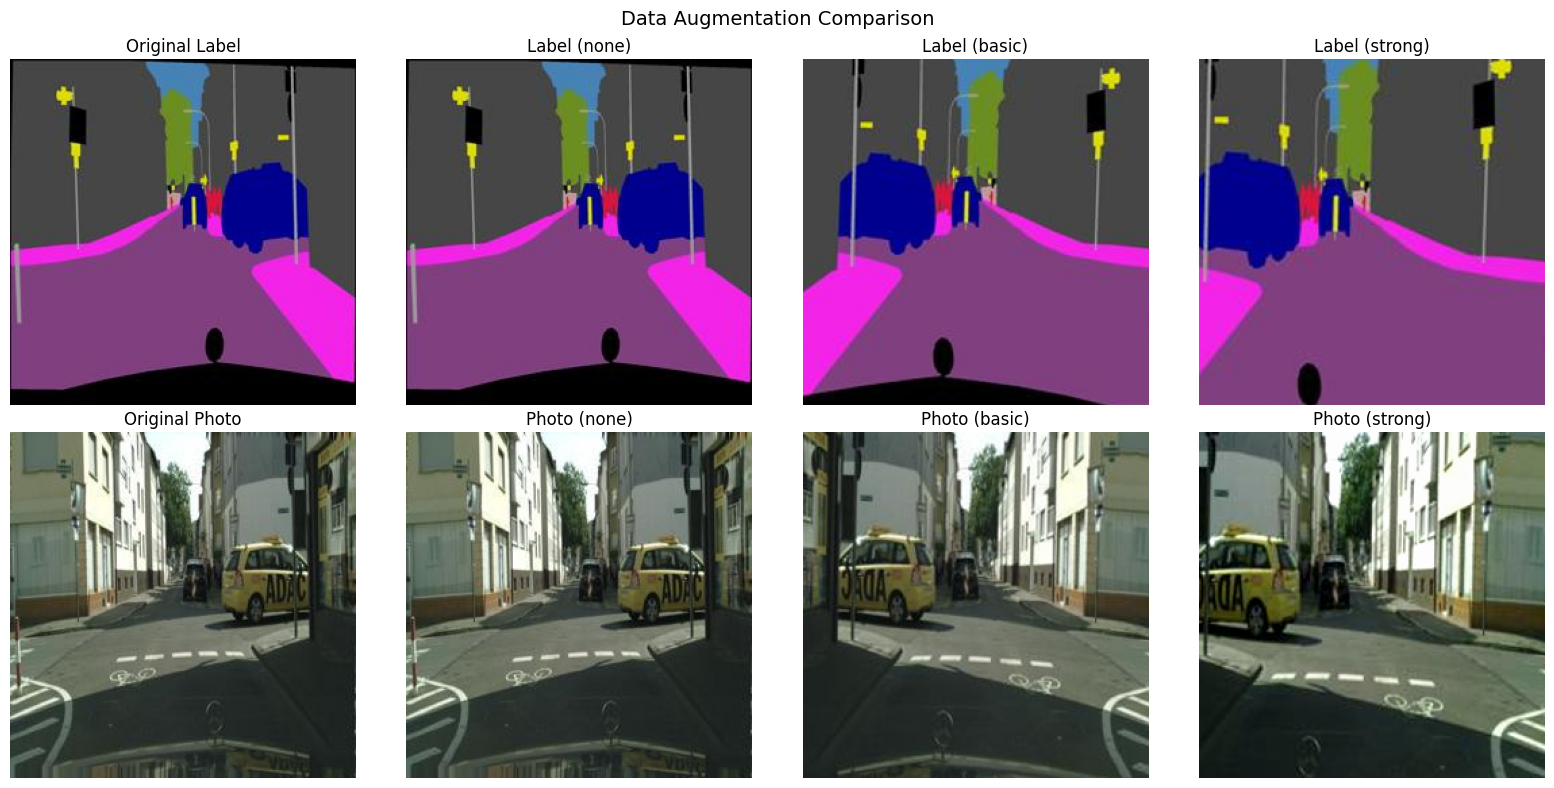

In [ ]:
# 加载一个样本进行可视化
test_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="val",
    split_index=SPLIT_INDEX,
    transform=None  # 先不应用transform，看原始图像
)

# 获取原始图像
sample = test_dataset[0]
label_orig = sample["label"]
photo_orig = sample["photo"]

# 可视化原始图像和三种增强配置
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Data Augmentation Comparison", fontsize=14)

# 第一行：Label
axes[0, 0].imshow(label_orig)
axes[0, 0].set_title("Original Label")
axes[0, 0].axis("off")

for col, (aug_name, transform) in enumerate(aug_configs.items(), 1):
    # 应用增强
    label_aug, photo_aug = transform(label_orig.copy(), photo_orig.copy())

    # 转换为图像格式（tensor -> numpy）
    def tensor_to_image(tensor):
        if isinstance(tensor, torch.Tensor):
            img = tensor.permute(1, 2, 0).cpu().numpy()
        else:
            img = np.array(tensor)
        if img.min() < 0:
            img = (img + 1) / 2
        img = np.clip(img, 0, 1)
        return img

    label_img = tensor_to_image(label_aug)
    photo_img = tensor_to_image(photo_aug)

    axes[0, col].imshow(label_img)
    axes[0, col].set_title(f"Label ({aug_name})")
    axes[0, col].axis("off")

    if col == 1:
        axes[1, 0].imshow(photo_orig)
        axes[1, 0].set_title("Original Photo")
        axes[1, 0].axis("off")

    axes[1, col].imshow(photo_img)
    axes[1, col].set_title(f"Photo ({aug_name})")
    axes[1, col].axis("off")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "augmentation_comparison.png", dpi=150, bbox_inches="tight")
plt.show()



In [ ]:
def save_triplet(label, generated, ground_truth, save_path):
    """保存三联图：Label / Generated / Ground Truth"""
    def tensor_to_image(tensor):
        if tensor.dim() == 3:
            img = tensor.permute(1, 2, 0).cpu().numpy()
        else:
            img = tensor[0].permute(1, 2, 0).cpu().numpy()
        if img.min() < 0:
            img = (img + 1) / 2
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        return img

    label_img = tensor_to_image(label)
    gen_img = tensor_to_image(generated)
    gt_img = tensor_to_image(ground_truth)

    triplet = np.hstack([label_img, gen_img, gt_img])
    Image.fromarray(triplet).save(save_path)


def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0.0
    num_batches = 0

    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        label = batch["label"].to(device)
        photo = batch["photo"].to(device)

        optimizer.zero_grad()
        generated = model(label)
        loss = criterion(generated, photo)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / num_batches if num_batches > 0 else 0.0


@torch.no_grad()
def validate(model, dataloader, criterion, device, num_samples=10, output_dir=None, aug_mode=""):
    """验证并保存三联图，同时计算评估指标"""
    model.eval()
    total_loss = 0.0
    num_batches = 0
    saved_samples = 0
    
    # 评估指标累计
    total_psnr = 0.0
    total_ssim = 0.0
    total_mae = 0.0
    
    if output_dir is None:
        # 默认将样例三联图保存到 outputs/images/unet_baseline
        output_dir = IMAGES_DIR

    pbar = tqdm(dataloader, desc="Validating")
    for batch in pbar:
        label = batch["label"].to(device)
        photo = batch["photo"].to(device)
        name = batch["name"]

        generated = model(label)
        loss = criterion(generated, photo)

        total_loss += loss.item()
        num_batches += 1
        
        # 计算评估指标
        metrics = evaluate_batch(generated, photo)
        total_psnr += metrics['psnr']
        total_ssim += metrics['ssim']
        total_mae += metrics['mae']

        if saved_samples < num_samples:
            # 保存样例时包含aug_mode标识
            if aug_mode:
                save_path = output_dir / f"sample_{saved_samples:02d}_{aug_mode}.png"
            else:
                save_path = output_dir / f"sample_{saved_samples:02d}.png"
            save_triplet(label, generated, photo, save_path)
            saved_samples += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    avg_psnr = total_psnr / num_batches if num_batches > 0 else 0.0
    avg_ssim = total_ssim / num_batches if num_batches > 0 else 0.0
    avg_mae = total_mae / num_batches if num_batches > 0 else 0.0
    
    return {
        'loss': avg_loss,
        'psnr': avg_psnr,
        'ssim': avg_ssim,
        'mae': avg_mae
    }



In [ ]:
# ============================================
# 训练配置 - 修改 aug_mode 来切换增强配置
# ============================================
# 三种配置：'none', 'basic', 'strong'
aug_mode = "none"  # ⚠️ 修改这里来切换配置
epochs = 200
batch_size = 16
lr = 2e-4
start_decay_epoch = 100

# 创建数据集
train_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="train",
    split_index=SPLIT_INDEX,
    transform=aug_configs[aug_mode]
)
val_dataset = CityscapesDataset(
    root=DATA_ROOT,
    split="val",
    split_index=SPLIT_INDEX,
    transform=val_transform
)

# 在Colab中，num_workers应该设置为0以避免多进程问题
# 在本地环境中可以使用2或更多
num_workers = 2  # 在 Colab 上通常设置为 2 是安全的
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True  # 建议开启，加速数据转入GPU
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 创建模型
model = UNetBaseline(in_channels=3, out_channels=3).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

# 学习率调度
def get_lr_scheduler(optimizer, num_epochs, start_decay_epoch):
    def lr_lambda(epoch):
        if epoch < start_decay_epoch:
            return 1.0
        else:
            return 1.0 - (epoch - start_decay_epoch) / (num_epochs - start_decay_epoch)
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, epochs, start_decay_epoch)

# 训练循环（记录评估指标）
train_losses = []
val_losses = []
val_psnrs = []
val_ssims = []
val_maes = []

print(f"🚀 Starting training with augmentation: {aug_mode}")
print(f"   Configuration: {aug_mode}")
print(f"   Epochs: {epochs}, Batch size: {batch_size}, LR: {lr}")

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_metrics = validate(model, val_loader, criterion, device, num_samples=10, aug_mode=aug_mode)

    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_metrics['loss'])
    val_psnrs.append(val_metrics['psnr'])
    val_ssims.append(val_metrics['ssim'])
    val_maes.append(val_metrics['mae'])

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_metrics['loss']:.4f}, "
              f"PSNR: {val_metrics['psnr']:.2f}dB, "
              f"SSIM: {val_metrics['ssim']:.4f}, "
              f"MAE: {val_metrics['mae']:.4f}, "
              f"LR: {current_lr:.6f}")

        # 保存checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_metrics['loss'],
            "val_psnr": val_metrics['psnr'],
            "val_ssim": val_metrics['ssim'],
            "val_mae": val_metrics['mae'],
        }, CHECKPOINT_DIR / f"checkpoint_{aug_mode}_epoch_{epoch:03d}.pth")

# 保存最终模型和训练历史
torch.save({
    "epoch": epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_psnrs": val_psnrs,
    "val_ssims": val_ssims,
    "val_maes": val_maes,
    "aug_mode": aug_mode,
}, CHECKPOINT_DIR / f"model_{aug_mode}_final.pth")

# 保存训练历史为JSON（方便后续对比）
import json
history = {
    "aug_mode": aug_mode,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_psnrs": val_psnrs,
    "val_ssims": val_ssims,
    "val_maes": val_maes,
}
with open(LOGS_DIR / f"history_{aug_mode}.json", "w") as f:
    json.dump(history, f, indent=2)

print(f"\n✅ Training complete! ({aug_mode})")
print(f"   Final Val Loss: {val_losses[-1]:.4f}")
print(f"   Final PSNR: {val_psnrs[-1]:.2f}dB")
print(f"   Final SSIM: {val_ssims[-1]:.4f}")
print(f"   Final MAE: {val_maes[-1]:.4f}")



Starting training with augmentation: none


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch 10/200 - Train Loss: 0.1722, Val Loss: 0.2069, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.77it/s]


Epoch 20/200 - Train Loss: 0.1422, Val Loss: 0.2097, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


Epoch 30/200 - Train Loss: 0.1240, Val Loss: 0.2113, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.71it/s]


Epoch 40/200 - Train Loss: 0.1103, Val Loss: 0.2104, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch 50/200 - Train Loss: 0.1007, Val Loss: 0.2108, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]


Epoch 60/200 - Train Loss: 0.0939, Val Loss: 0.2102, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]


Epoch 70/200 - Train Loss: 0.0888, Val Loss: 0.2130, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]


Epoch 80/200 - Train Loss: 0.0846, Val Loss: 0.2126, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


Epoch 90/200 - Train Loss: 0.0809, Val Loss: 0.2115, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]


Epoch 100/200 - Train Loss: 0.0777, Val Loss: 0.2118, LR: 0.000200


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.69it/s]


Epoch 110/200 - Train Loss: 0.0744, Val Loss: 0.2126, LR: 0.000180


Validating: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 120/200 - Train Loss: 0.0717, Val Loss: 0.2124, LR: 0.000160


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]


Epoch 130/200 - Train Loss: 0.0690, Val Loss: 0.2135, LR: 0.000140


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s]


Epoch 140/200 - Train Loss: 0.0668, Val Loss: 0.2133, LR: 0.000120


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.62it/s]


Epoch 150/200 - Train Loss: 0.0650, Val Loss: 0.2135, LR: 0.000100


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.59it/s]


Epoch 160/200 - Train Loss: 0.0633, Val Loss: 0.2144, LR: 0.000080


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.58it/s]


Epoch 170/200 - Train Loss: 0.0618, Val Loss: 0.2148, LR: 0.000060


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.29it/s]


Epoch 180/200 - Train Loss: 0.0607, Val Loss: 0.2143, LR: 0.000040


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.68it/s]


Epoch 190/200 - Train Loss: 0.0597, Val Loss: 0.2152, LR: 0.000020


Validating: 100%|██████████| 32/32 [00:03<00:00,  8.72it/s]


Epoch 200/200 - Train Loss: 0.0592, Val Loss: 0.2153, LR: 0.000000

✅ Training complete! (none)


### 5.3 强增强配置

> **注意**：训练强增强配置时，修改 `aug_mode = "strong"`。



## 6. 可视化训练结果

### 6.1 训练损失曲线



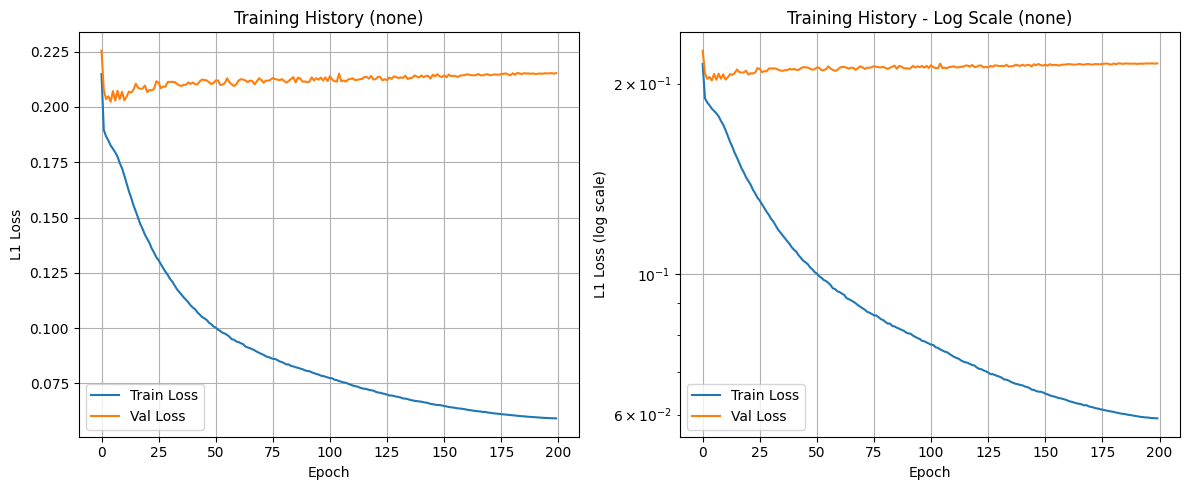

In [ ]:
# 加载训练历史（如果有多个配置，可以加载并对比）
# 这里展示如何绘制损失曲线

# 示例：绘制单个配置的损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title(f"Training History ({aug_mode})")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss (log scale)")
plt.yscale("log")
plt.title(f"Training History - Log Scale ({aug_mode})")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f"training_curve_{aug_mode}.png", dpi=150, bbox_inches="tight")
plt.show()



### 6.2 生成结果可视化



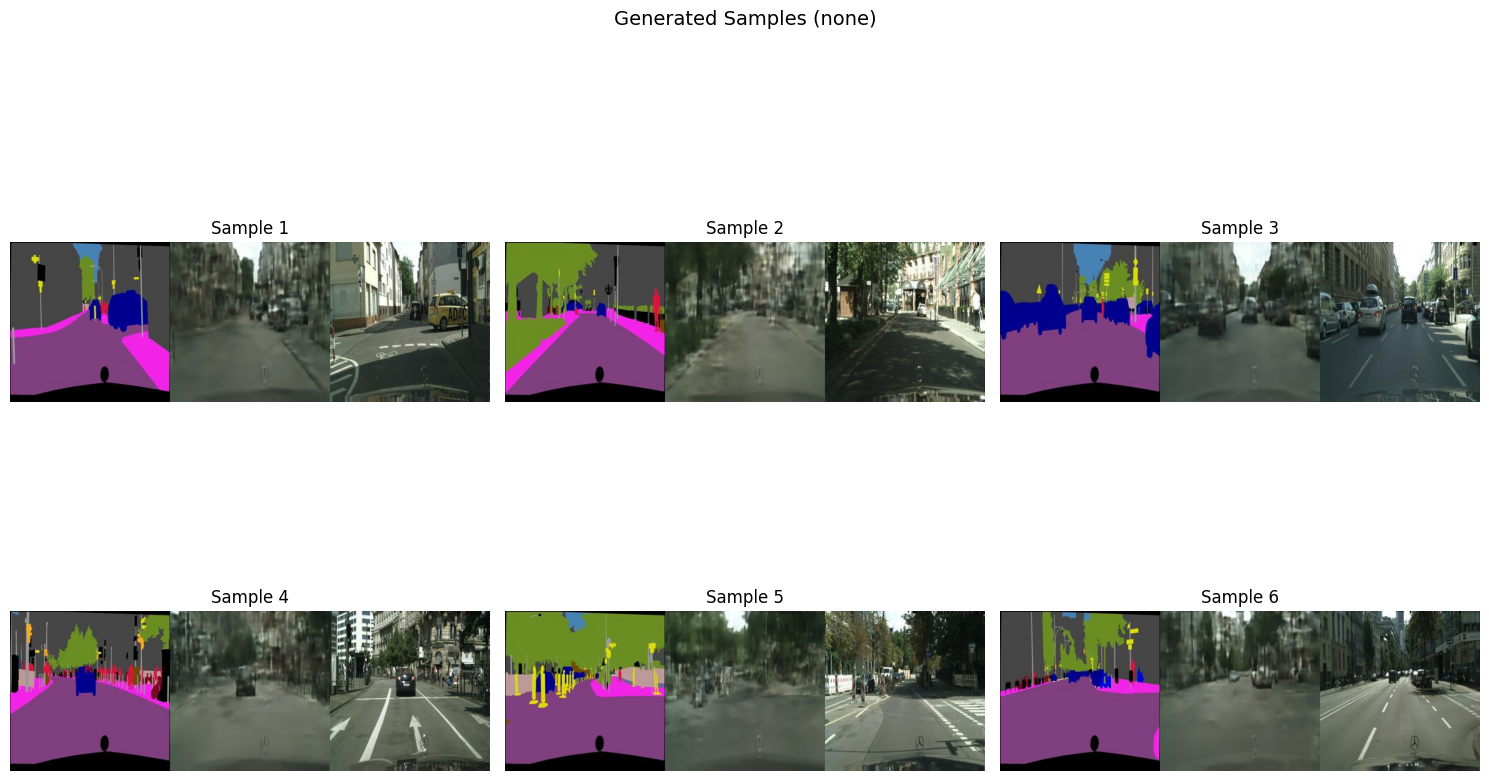

In [ ]:
# 加载保存的三联图并展示
import glob

sample_images = sorted(glob.glob(str(IMAGES_DIR / "sample_*.png")))[:6]

if sample_images:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Generated Samples ({aug_mode})", fontsize=14)

    for idx, img_path in enumerate(sample_images):
        row = idx // 3
        col = idx % 3
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Sample {idx + 1}")
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"samples_{aug_mode}.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("No sample images found. Run validation to generate samples.")



## 7. 数据增强消融实验完整流程

### 7.1 消融实验步骤说明

**重要：请按顺序完成以下步骤**

1. **第一步**：运行上面的训练代码（Cell 13），设置 `aug_mode = "none"`，完成无增强训练
2. **第二步**：修改 `aug_mode = "basic"`，重新运行 Cell 13，完成基础增强训练
3. **第三步**：修改 `aug_mode = "strong"`，重新运行 Cell 13，完成强增强训练
4. **第四步**：运行下面的对比分析代码（Cell 20+），生成消融实验报告

**注意**：每次训练会保存：
- 模型文件：`model_{aug_mode}_final.pth`
- 训练历史：`history_{aug_mode}.json`
- 损失曲线图：`training_curve_{aug_mode}.png`
- 生成样例：`sample_*.png`

---

### 7.2 加载所有配置的训练历史并对比



In [ ]:
# ============================================
# 消融实验对比分析
# ============================================
# 加载三种配置的训练历史

aug_modes = ["none", "basic", "strong"]
histories = {}

for aug_mode in aug_modes:
    history_path = LOGS_DIR / f"history_{aug_mode}.json"
    if history_path.exists():
        with open(history_path, "r") as f:
            histories[aug_mode] = json.load(f)
        print(f"✅ 已加载 {aug_mode} 的训练历史")
    else:
        print(f"⚠️  未找到 {aug_mode} 的训练历史: {history_path}")

if len(histories) == 0:
    print("\n❌ 未找到任何训练历史！请先完成训练。")
else:
    print(f"\n📊 已加载 {len(histories)} 个配置的训练历史")


### 7.3 对比损失曲线


In [ ]:
# 绘制三种配置的损失曲线对比
if len(histories) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 训练损失对比
    ax = axes[0, 0]
    for aug_mode, history in histories.items():
        epochs = range(1, len(history['train_losses']) + 1)
        ax.plot(epochs, history['train_losses'], label=f"Train ({aug_mode})", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("L1 Loss")
    ax.set_title("Training Loss Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 验证损失对比
    ax = axes[0, 1]
    for aug_mode, history in histories.items():
        epochs = range(1, len(history['val_losses']) + 1)
        ax.plot(epochs, history['val_losses'], label=f"Val ({aug_mode})", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("L1 Loss")
    ax.set_title("Validation Loss Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # PSNR对比
    ax = axes[1, 0]
    for aug_mode, history in histories.items():
        epochs = range(1, len(history['val_psnrs']) + 1)
        ax.plot(epochs, history['val_psnrs'], label=f"{aug_mode}", linewidth=2, marker='o', markersize=3)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("PSNR (dB)")
    ax.set_title("PSNR Comparison (Higher is Better)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # SSIM对比
    ax = axes[1, 1]
    for aug_mode, history in histories.items():
        epochs = range(1, len(history['val_ssims']) + 1)
        ax.plot(epochs, history['val_ssims'], label=f"{aug_mode}", linewidth=2, marker='s', markersize=3)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("SSIM")
    ax.set_title("SSIM Comparison (Higher is Better)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "ablation_comparison_curves.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("请先完成训练并加载训练历史")


### 7.4 最终指标对比表


In [ ]:
# 生成最终指标对比表
if len(histories) > 0:
    import pandas as pd
    
    results = []
    for aug_mode, history in histories.items():
        final_epoch = len(history['val_losses']) - 1
        results.append({
            "Augmentation": aug_mode,
            "Final Val Loss": f"{history['val_losses'][final_epoch]:.4f}",
            "Final PSNR (dB)": f"{history['val_psnrs'][final_epoch]:.2f}",
            "Final SSIM": f"{history['val_ssims'][final_epoch]:.4f}",
            "Final MAE": f"{history['val_maes'][final_epoch]:.4f}",
            "Best PSNR (dB)": f"{max(history['val_psnrs']):.2f}",
            "Best SSIM": f"{max(history['val_ssims']):.4f}",
            "Best Epoch (PSNR)": history['val_psnrs'].index(max(history['val_psnrs'])) + 1,
        })
    
    df = pd.DataFrame(results)
    print("\n" + "="*80)
    print("📊 数据增强消融实验最终结果对比")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # 保存为CSV（训练日志）
    df.to_csv(LOGS_DIR / "ablation_results.csv", index=False)
    print(f"\n✅ 结果已保存到: {LOGS_DIR / 'ablation_results.csv'}")
    
    # 可视化指标对比（柱状图）
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    aug_names = [r['Augmentation'] for r in results]
    psnrs = [float(r['Final PSNR (dB)']) for r in results]
    ssims = [float(r['Final SSIM']) for r in results]
    maes = [float(r['Final MAE']) for r in results]
    
    # PSNR对比
    axes[0].bar(aug_names, psnrs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_ylabel("PSNR (dB)")
    axes[0].set_title("PSNR Comparison (Higher is Better)")
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(psnrs):
        axes[0].text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')
    
    # SSIM对比
    axes[1].bar(aug_names, ssims, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1].set_ylabel("SSIM")
    axes[1].set_title("SSIM Comparison (Higher is Better)")
    axes[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(ssims):
        axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom')
    
    # MAE对比
    axes[2].bar(aug_names, maes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[2].set_ylabel("MAE")
    axes[2].set_title("MAE Comparison (Lower is Better)")
    axes[2].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(maes):
        axes[2].text(i, v + 0.002, f"{v:.4f}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "ablation_metrics_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("请先完成训练并加载训练历史")


### 7.5 生成结果可视化对比


In [ ]:
# 对比三种配置的生成结果
if len(histories) > 0:
    import glob
    
    # 为每种配置加载样例图像
    sample_dict = {}
    for aug_mode in aug_modes:
        samples = sorted(glob.glob(str(IMAGES_DIR / f"sample_*_{aug_mode}.png")))
        if not samples:
            # 尝试查找通用格式
            samples = sorted(glob.glob(str(IMAGES_DIR / f"sample_*.png")))
        sample_dict[aug_mode] = samples[:6]  # 每种配置取前6张
    
    # 如果找到了样例，进行可视化
    if any(sample_dict.values()):
        num_samples = min(len(samples) for samples in sample_dict.values() if samples)
        if num_samples > 0:
            fig, axes = plt.subplots(num_samples, len(aug_modes) + 1, figsize=(20, 4 * num_samples))
            fig.suptitle("Generated Samples Comparison: Label | None | Basic | Strong", fontsize=16)
            
            for row in range(num_samples):
                # 第一列：Label（从第一个配置获取）
                for aug_mode in aug_modes:
                    if sample_dict[aug_mode]:
                        label_img = Image.open(sample_dict[aug_mode][row])
                        # 提取左侧的label部分
                        w, h = label_img.size
                        label_part = label_img.crop((0, 0, w // 3, h))
                        axes[row, 0].imshow(label_part)
                        axes[row, 0].set_title("Label" if row == 0 else "")
                        axes[row, 0].axis("off")
                        break
                
                # 其他列：不同配置的生成结果
                for col, aug_mode in enumerate(aug_modes, 1):
                    if sample_dict[aug_mode] and row < len(sample_dict[aug_mode]):
                        img = Image.open(sample_dict[aug_mode][row])
                        # 提取中间的生成结果部分
                        w, h = img.size
                        gen_part = img.crop((w // 3, 0, 2 * w // 3, h))
                        axes[row, col].imshow(gen_part)
                        if row == 0:
                            axes[row, col].set_title(f"{aug_mode.upper()}")
                        axes[row, col].axis("off")
            
            plt.tight_layout()
            plt.savefig(FIGURES_DIR / "ablation_samples_comparison.png", dpi=150, bbox_inches="tight")
            plt.show()
        else:
            print("未找到足够的样例图像")
    else:
        print("⚠️  未找到样例图像。请确保训练时保存了样例（validate函数中的num_samples > 0）")
else:
    print("请先完成训练并加载训练历史")


### 7.6 消融实验总结与分析

运行下面的代码生成分析报告：


In [ ]:
# 生成消融实验分析报告
if len(histories) > 0:
    report = []
    report.append("="*80)
    report.append("数据增强消融实验分析报告")
    report.append("="*80)
    report.append("")
    
    # 配置说明
    report.append("【实验配置】")
    report.append(f"  模型: U-Net Baseline (仅L1损失)")
    report.append(f"  训练轮数: 200 epochs")
    report.append(f"  学习率: 2e-4 (从epoch 100开始线性衰减)")
    report.append(f"  Batch size: 16")
    report.append("")
    
    # 增强配置说明
    report.append("【数据增强配置】")
    report.append("  1. none: 无增强（仅resize到256x256）")
    report.append("  2. basic: 基础增强（随机jitter + 水平翻转）")
    report.append("  3. strong: 强增强（jitter + 翻转 + 颜色抖动 + 随机缩放）")
    report.append("")
    
    # 结果对比
    report.append("【实验结果对比】")
    for aug_mode, history in histories.items():
        final_idx = len(history['val_losses']) - 1
        best_psnr_idx = history['val_psnrs'].index(max(history['val_psnrs']))
        
        report.append(f"\n  {aug_mode.upper()} 配置:")
        report.append(f"    最终验证损失: {history['val_losses'][final_idx]:.4f}")
        report.append(f"    最终PSNR: {history['val_psnrs'][final_idx]:.2f} dB")
        report.append(f"    最终SSIM: {history['val_ssims'][final_idx]:.4f}")
        report.append(f"    最终MAE: {history['val_maes'][final_idx]:.4f}")
        report.append(f"    最佳PSNR: {max(history['val_psnrs']):.2f} dB (Epoch {best_psnr_idx + 1})")
        report.append(f"    最佳SSIM: {max(history['val_ssims']):.4f}")
    
    # 分析
    report.append("\n【分析结论】")
    
    # 找出最佳配置
    best_psnr_config = max(histories.items(), key=lambda x: max(x[1]['val_psnrs']))
    best_ssim_config = max(histories.items(), key=lambda x: max(x[1]['val_ssims']))
    best_mae_config = min(histories.items(), key=lambda x: x[1]['val_maes'][-1])
    
    report.append(f"  1. PSNR最佳配置: {best_psnr_config[0]} ({max(best_psnr_config[1]['val_psnrs']):.2f} dB)")
    report.append(f"  2. SSIM最佳配置: {best_ssim_config[0]} ({max(best_ssim_config[1]['val_ssims']):.4f})")
    report.append(f"  3. MAE最佳配置: {best_mae_config[0]} ({best_mae_config[1]['val_maes'][-1]:.4f})")
    report.append("")
    
    # 训练稳定性分析
    report.append("【训练稳定性分析】")
    for aug_mode, history in histories.items():
        val_loss_range = max(history['val_losses']) - min(history['val_losses'])
        val_loss_std = np.std(history['val_losses'][-50:])  # 最后50个epoch的标准差
        report.append(f"  {aug_mode}: 验证损失波动范围={val_loss_range:.4f}, 后期标准差={val_loss_std:.4f}")
    
    report.append("")
    report.append("="*80)
    
    # 打印报告
    report_text = "\n".join(report)
    print(report_text)
    
    # 保存报告到日志目录
    with open(LOGS_DIR / "ablation_report.txt", "w", encoding="utf-8") as f:
        f.write(report_text)
    print(f"\n✅ 分析报告已保存到: {LOGS_DIR / 'ablation_report.txt'}")
else:
    print("请先完成训练并加载训练历史")


## 8. 从 Google Drive 恢复旧输出并整理到标准目录

如果你之前把训练结果保存到了 Google Drive 的 `Rescue_Output` 文件夹，运行下面的代码可以：
1. 从 Drive 读取所有文件
2. 按照 README 要求的目录结构整理
3. 推送到 GitHub



In [ ]:
# ============================================
# 从 Google Drive 恢复旧输出并整理到标准目录
# ============================================

import os
import shutil
from pathlib import Path
import subprocess

# 确保 Google Drive 已挂载
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive 已挂载")
except:
    print("⚠️  不在 Colab 环境，跳过 Drive 挂载")

# 路径配置
ROOT = Path("/content/Image-to-Image-Translation-Experiment")
DRIVE_RESCUE_DIR = Path("/content/drive/MyDrive/Rescue_Output")

# 目标目录（按照 README 要求）
CHECKPOINT_DIR = ROOT / "outputs" / "checkpoints" / "unet_baseline"
IMAGES_DIR = ROOT / "outputs" / "images" / "unet_baseline"
FIGURES_DIR = ROOT / "outputs" / "figures" / "unet_baseline"
LOGS_DIR = ROOT / "outputs" / "logs" / "unet_baseline"

# 创建目标目录
for d in [CHECKPOINT_DIR, IMAGES_DIR, FIGURES_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📁 源目录: {DRIVE_RESCUE_DIR}")
print(f"📁 目标目录:")
print(f"   - Checkpoints: {CHECKPOINT_DIR}")
print(f"   - Images: {IMAGES_DIR}")
print(f"   - Figures: {FIGURES_DIR}")
print(f"   - Logs: {LOGS_DIR}")

# 检查源目录是否存在
if not DRIVE_RESCUE_DIR.exists():
    print(f"\n❌ 错误: 未找到源目录 {DRIVE_RESCUE_DIR}")
    print("   请确保 Rescue_Output 文件夹在 Google Drive 的根目录下")
else:
    print(f"\n✅ 找到源目录: {DRIVE_RESCUE_DIR}")
    
    # 统计文件
    copied_files = {
        'checkpoints': [],
        'images': [],
        'figures': [],
        'logs': []
    }
    
    # 1. 处理 checkpoints 目录
    drive_checkpoints = DRIVE_RESCUE_DIR / "checkpoints"
    if drive_checkpoints.exists():
        print(f"\n📦 处理 checkpoints...")
        for file in drive_checkpoints.rglob("*"):
            if file.is_file() and file.suffix in ['.pth', '.pt']:
                # 只复制 unet_baseline 相关的模型文件
                if 'unet' in file.name.lower() or 'baseline' in file.name.lower() or 'none' in file.name.lower():
                    dest = CHECKPOINT_DIR / file.name
                    shutil.copy2(file, dest)
                    copied_files['checkpoints'].append(file.name)
                    print(f"   ✅ {file.name}")
    
    # 2. 处理旧目录 unet_baseline 中的 checkpoints
    old_unet_dir = DRIVE_RESCUE_DIR / "unet_baseline"
    if old_unet_dir.exists():
        print(f"\n📦 处理旧目录 unet_baseline 中的 checkpoints...")
        for file in old_unet_dir.glob("*.pth"):
            if 'checkpoint' in file.name or 'model' in file.name:
                dest = CHECKPOINT_DIR / file.name
                shutil.copy2(file, dest)
                copied_files['checkpoints'].append(file.name)
                print(f"   ✅ {file.name}")
    
    # 3. 处理 images 目录（三联图）
    drive_images = DRIVE_RESCUE_DIR / "images"
    if drive_images.exists():
        print(f"\n🖼️  处理 images...")
        for file in drive_images.rglob("*.png"):
            if 'sample' in file.name.lower() or 'none' in file.name.lower():
                dest = IMAGES_DIR / file.name
                shutil.copy2(file, dest)
                copied_files['images'].append(file.name)
                print(f"   ✅ {file.name}")
    
    # 4. 处理旧目录中的 sample 图片
    if old_unet_dir.exists():
        print(f"\n🖼️  处理旧目录中的 sample 图片...")
        for file in old_unet_dir.glob("sample_*.png"):
            dest = IMAGES_DIR / file.name
            shutil.copy2(file, dest)
            copied_files['images'].append(file.name)
            print(f"   ✅ {file.name}")
    
    # 5. 处理 figures 目录（曲线图、对比图）
    drive_figures = DRIVE_RESCUE_DIR / "figures"
    if drive_figures.exists():
        print(f"\n📊 处理 figures...")
        for file in drive_figures.rglob("*.png"):
            if 'unet' in file.name.lower() or 'baseline' in file.name.lower() or 'none' in file.name.lower() or 'curve' in file.name.lower() or 'sample' in file.name.lower():
                dest = FIGURES_DIR / file.name
                shutil.copy2(file, dest)
                copied_files['figures'].append(file.name)
                print(f"   ✅ {file.name}")
    
    # 6. 处理旧目录中的图表
    if old_unet_dir.exists():
        print(f"\n📊 处理旧目录中的图表...")
        for pattern in ["*curve*.png", "*sample*.png", "*comparison*.png", "*augmentation*.png"]:
            for file in old_unet_dir.glob(pattern):
                dest = FIGURES_DIR / file.name
                shutil.copy2(file, dest)
                copied_files['figures'].append(file.name)
                print(f"   ✅ {file.name}")
    
    # 7. 处理 logs 目录（训练历史、日志）
    drive_logs = DRIVE_RESCUE_DIR / "logs"
    if drive_logs.exists():
        print(f"\n📝 处理 logs...")
        for file in drive_logs.rglob("*"):
            if file.is_file() and file.suffix in ['.json', '.csv', '.txt']:
                if 'unet' in file.name.lower() or 'baseline' in file.name.lower() or 'none' in file.name.lower() or 'history' in file.name.lower() or 'ablation' in file.name.lower():
                    dest = LOGS_DIR / file.name
                    shutil.copy2(file, dest)
                    copied_files['logs'].append(file.name)
                    print(f"   ✅ {file.name}")
    
    # 8. 处理旧目录中的日志文件
    if old_unet_dir.exists():
        print(f"\n📝 处理旧目录中的日志文件...")
        for pattern in ["*.json", "*.csv", "*.txt"]:
            for file in old_unet_dir.glob(pattern):
                if 'history' in file.name.lower() or 'ablation' in file.name.lower() or 'log' in file.name.lower():
                    dest = LOGS_DIR / file.name
                    shutil.copy2(file, dest)
                    copied_files['logs'].append(file.name)
                    print(f"   ✅ {file.name}")
    
    # 统计结果
    print("\n" + "="*60)
    print("📊 文件复制统计")
    print("="*60)
    print(f"Checkpoints: {len(copied_files['checkpoints'])} 个文件")
    print(f"Images: {len(copied_files['images'])} 个文件")
    print(f"Figures: {len(copied_files['figures'])} 个文件")
    print(f"Logs: {len(copied_files['logs'])} 个文件")
    total = sum(len(v) for v in copied_files.values())
    print(f"\n总计: {total} 个文件")
    print("="*60)



In [ ]:
# ============================================
# 提交并推送到 GitHub
# ============================================

import subprocess
import os

# 切换到项目根目录
os.chdir(ROOT)

# 配置 Git（如果需要）
try:
    # 检查 git 状态
    result = subprocess.run(["git", "status"], capture_output=True, text=True)
    print("📋 Git 状态:")
    print(result.stdout)
    
    # 添加所有输出文件
    print("\n📦 添加文件到 Git...")
    subprocess.run(["git", "add", "outputs/checkpoints/unet_baseline/"], check=False)
    subprocess.run(["git", "add", "outputs/images/unet_baseline/"], check=False)
    subprocess.run(["git", "add", "outputs/figures/unet_baseline/"], check=False)
    subprocess.run(["git", "add", "outputs/logs/unet_baseline/"], check=False)
    
    # 检查是否有变更
    result = subprocess.run(["git", "status", "--short"], capture_output=True, text=True)
    if result.stdout.strip():
        print("\n📝 准备提交以下文件:")
        print(result.stdout)
        
        # 提交
        commit_msg = "Add UNet baseline outputs (none augmentation) - organized by README structure"
        print(f"\n💾 提交信息: {commit_msg}")
        subprocess.run(["git", "commit", "-m", commit_msg], check=False)
        
        # 推送到 GitHub
        print("\n🚀 推送到 GitHub...")
        push_result = subprocess.run(["git", "push"], capture_output=True, text=True)
        if push_result.returncode == 0:
            print("✅ 成功推送到 GitHub!")
        else:
            print("⚠️  推送可能失败，请检查:")
            print(push_result.stdout)
            print(push_result.stderr)
            print("\n💡 提示: 如果推送失败，可能需要:")
            print("   1. 配置 Git 用户信息: git config user.name 'Your Name'")
            print("   2. 配置 Git 邮箱: git config user.email 'your.email@example.com'")
            print("   3. 使用 Personal Access Token 作为密码")
    else:
        print("\n✅ 没有新文件需要提交（可能已经提交过了）")
        
except subprocess.CalledProcessError as e:
    print(f"\n❌ Git 操作出错: {e}")
    print("   请手动执行以下命令:")
    print(f"   cd {ROOT}")
    print("   git add outputs/checkpoints/unet_baseline/")
    print("   git add outputs/images/unet_baseline/")
    print("   git add outputs/figures/unet_baseline/")
    print("   git add outputs/logs/unet_baseline/")
    print("   git commit -m 'Add UNet baseline outputs'")
    print("   git push")
except FileNotFoundError:
    print("\n⚠️  Git 未安装或不在 Git 仓库中")
    print("   请确保:")
    print("   1. 项目已初始化为 Git 仓库")
    print("   2. 已配置 GitHub remote")
    print("   3. 或者手动执行上述 Git 命令")

